## Automated PDF Extraction and Summarization Using NLP and OCR

#### This project focuses on automating the extraction of critical information from PDF documents, using NLP techniques, machine learning, and data visualization. The process includes text extraction, invoice data retrieval, summarization, word frequency analysis, and sentiment evaluation, offering a robust solution for managing document-heavy workflows.

In [2]:
#!pip install textract
#!pip install pdfplumber
#!pip install wordcloud
#!pip install pip==23.0.1
#!pip install textract
#!pip uninstall pdfminer -y
#!pip uninstall pdfminer.six -y
#!pip install pdfminer.six
#!pip install tensorflow
#!python -m spacy download en_core_web_sm
#!pip uninstall keras -y
#!pip install tf-keras

In [3]:
import os  # Used for interacting with the file system (e.g., getting the list of files in a directory)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import pdfplumber  # Library to extract text from PDFs (optional in this case as we use textract)
import spacy  # NLP library used for named entity recognition (e.g., extracting dates from text)
import re  # Regular expressions for pattern matching and text cleaning
from dateutil.parser import parse  # Helps parse dates in various formats
from collections import Counter  # Used for counting word frequencies
import seaborn as sns  # Visualization library for plotting graphs
import matplotlib.pyplot as plt  # Visualization library for plotting charts
from wordcloud import WordCloud  # Library to generate word cloud visualizations
import pandas as pd  # Data manipulation library
from transformers import pipeline  # HuggingFace's transformers for NLP models, like summarization
import textract  # A tool to extract text from PDFs and other files

### Step 1: Set the working directory and get all PDF files in the 'Data' folder

In [5]:
# # URL of the online open-source PDF (replace with the actual PDF URL)
# url = 'https://arxiv.org/pdf/2001.00798.pdf'  # Example PDF from arXiv
# response = requests.get(url)

# # Save the PDF file locally
# pdf_filename = "sample_downloaded.pdf"
# with open(pdf_filename, 'wb') as f:
#     f.write(response.content)

# print(f"Downloaded {pdf_filename} successfully!")

def get_pdf_files():
    cwd = os.getcwd() # Get the current working directory path
    data_folder = os.path.join(cwd, 'Data') # Construct the path to the 'Data' folder where PDFs are stored
    all_pdfs = [os.path.join(data_folder, file) for file in os.listdir(data_folder) if file.endswith('.pdf')] # List all files in the 'Data' folder and filter for PDF files only
    return all_pdfs

# Store the list of all PDF file paths
all_pdfs = get_pdf_files()
all_pdfs

['/Users/yutengzhang/Documents/PDF Extract NLP/Data/BD1-1421.pdf',
 '/Users/yutengzhang/Documents/PDF Extract NLP/Data/INV_UCB_19847612.pdf',
 '/Users/yutengzhang/Documents/PDF Extract NLP/Data/09f8cfb0-d649-0137.pdf',
 '/Users/yutengzhang/Documents/PDF Extract NLP/Data/201051107425035.pdf',
 '/Users/yutengzhang/Documents/PDF Extract NLP/Data/202076540912.pdf',
 '/Users/yutengzhang/Documents/PDF Extract NLP/Data/ISMP23497211.pdf']

### Step 2: Load spaCy language model

In [7]:
nlp = spacy.load("en_core_web_sm") # Load a small pre-trained English NLP model for tasks like named entity recognition

### Step 3: Clean and extract text using pdfplumber or textract

In [9]:
def clean_text(file_path):
    text = textract.process(file_path, method='tesseract') # Extract text from the PDF file using OCR method 'tesseract' (optical character recognition)
    text = text.decode('utf-8') # Decode the extracted text from bytes to a string format
    text = text.replace("\r\n", " ").replace("\n", " ") # Remove newlines and replace them with spaces to maintain text flow
    text = re.sub(r"\s+", " ", text) # Use regular expressions to replace multiple whitespace characters with a single space
    return text

In [10]:
# Check results with the PDF file (here I use the second file as an example)
file_text = clean_text(all_pdfs[1])
print("\n--- Cleaned Text ---\n")
print(file_text[:500] + '...')  # Show a snippet of the cleaned text


--- Cleaned Text ---

heed Page 1 of 2 Invoice n. 90000178 Document date: 08 January 2019 Packaging Information Number of pieces 2 Pallet Total number of units: 2 Piece Invoice Details VAT registration no: BE0810940487 Payer: 20000391 Your reference: BEBRA00003420904 Our reference: 93209634 Order date: 21 Sep 2018 Terms of delivery: EXW BRAINE L’ALLEUD Mode of transport: Boat - Collected Currency: EUR Material Code Description Batch Quantity Amount Value CIA03203 KEPPRA IV S00MG/5ML 10VIA RB GSK CL 18054 1.895 EA Gro...


### Step 4: Extract keyword-specific information (in this example file is "invoice")

In [12]:
def get_invoice_number(text):
    # Define keywords that might appear near the invoice number
    keywords = ["invoice number", "lading number", "invoice", "lading", "number"]
    text = text.lower() # Convert the text to lowercase for case-insensitive searching
    valid_matches = [] # Initialize a list to store valid matches for the invoice number

    # Loop through each keyword and search for it in the text
    for keyword in keywords:
        token = extract_tag_data(keyword, text, 'reverse') # Search in reverse direction
        if token:
            valid_matches.append(token.upper()) # Convert the result to uppercase for uniformity

    # Check if there were any valid matches, then use the first one as the invoice number
    if valid_matches:
        invoice_number = valid_matches[0]
        if len(invoice_number) > 20:
            invoice_number = invoice_number.split('/')[0] # If the invoice number is unusually long, split it and use the first part
    else:
        invoice_number = "No Invoice Number found"
    
    return invoice_number

# Extract a string based on a tag (keyword) found in the text
def extract_tag_data(tag, text, direction='forward'):
    token = ''
    start_pos = get_tag_position(tag, text, direction=direction) # Find the position of the tag
    if start_pos > 0:
        temp_corpus = text[start_pos:] # Extract the portion of text starting after the tag
        token = temp_corpus.split('|')[0] # Split the text and take the first segment
    return token

# Get the position of a tag in the text, searching either forward or backward
def get_tag_position(tag, text, direction='forward'):
    tag = tag.lower() # Convert tag to lowercase for case-insensitive matching
    # Search for the tag in the text, either forward or reverse
    if direction == 'reverse':
        tag_pos = text.lower().rfind(tag) # Find the last occurrence (reverse search)
    else:
        tag_pos = text.lower().find(tag) # Find the first occurrence (forward search)
    # Calculate the position after the tag, or return -1 if the tag is not found
    if tag_pos > 0:
        start_pos = tag_pos + len(tag) + 1
    else:
        start_pos = -1
    return start_pos

# Try to extract potential dates from the text around the keyword "invoice date"
def get_invoice_date(text):
    possible_dates = []
    temp_corpus = text[get_tag_position("invoice date", text):] # Extract text starting from "invoice date"
    doc = nlp(temp_corpus) # Process the text using spaCy for entity recognition
    possible_dates = [ent.text for ent in doc.ents if ent.label_ == "DATE"] # Extract entities labeled as dates
    
    temp_corpus = text[get_tag_position("date", text):] # Also search for just "date" keyword in case "invoice date" is not found
    doc = nlp(temp_corpus)
    possible_dates += [ent.text for ent in doc.ents if ent.label_ == "DATE"]

    # Use dateutil's parser to attempt to convert tokens into valid date formats
    tokens = text.split()
    for token in tokens:
        if len(token) >= 4:
            try:
                converted_date = parse(token)
                possible_dates.append(str(converted_date))
            except:
                continue

    # Validate and return the first valid date found, or return a default message if no date is found
    valid_dates = []
    for date in possible_dates:
        try:
            converted_date = parse(date)
            valid_dates.append(str(converted_date))
        except:
            continue
    
    if valid_dates:
        return valid_dates[0]
    else:
        return "No Invoice Date Found"

# Convert text to lowercase for case-insensitive matching
def get_invoice_amount(text):
    text = text.lower()
    invoice_amount = "" # Initialize the invoice amount as an empty string
    amounts = parse_amounts(text) # Try to extract amounts that follow standard patterns using regular expressions
    
    if amounts:
        invoice_amount = amounts[-1] # Use the last amount found in the text
    else:
        # Search for the total amount by looking for the keyword "total"
        temp_corpus = text[get_tag_position("total", text, direction='reverse'):]
        numbers = re.findall(r"\d+", temp_corpus) # Extract numbers near "total"
        if numbers:
            invoice_amount = numbers[0] # Use the first number found
    
    return invoice_amount

# Define a regular expression to match currency amounts (e.g., "$123.45", "123.45")
def parse_amounts(text):
    money_regex = re.compile(r"\$?\d+\,?\d*\.?\d{1,2}") 
    matches = re.findall(money_regex, text) # Find all matches in the text that look like currency amounts
    return [i.strip() for i in matches] # Return a list of clean matches

In [13]:
# Check results (here randomly select the 3rd pdf file as an example)
# Clean the text from the PDF
file_text = clean_text(all_pdfs[2])
    
# Print invoice information
print("\n--- Invoice Information ---\n")
    
# Extract and print the invoice number
invoice_number = get_invoice_number(file_text)
print(f"Invoice Number: {invoice_number}")
    
# Extract and print the invoice date
invoice_date = get_invoice_date(file_text)
print(f"Invoice Date: {invoice_date}")
    
# Extract and print the invoice amount
invoice_amount = get_invoice_amount(file_text)
print(f"Invoice Amount: {invoice_amount}")
    
print("\n--- End of Invoice Information ---\n")


--- Invoice Information ---

Invoice Number:  CMDU S703 7
Invoice Date: 2019-09-29 00:00:00
Invoice Amount: 736

--- End of Invoice Information ---



### Step 5: Text Summarization using BART Transformer Model

In [15]:
# Load BART model for summarization
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

def summarize_text(text):
    max_text_length = 1024 # BART can only process chunks of text up to a certain length (1024 tokens)
    chunks = [text[i:i+max_text_length] for i in range(0, len(text), max_text_length)] # Split the input text into chunks of 1024 tokens for summarization
    
    # Summarize each chunk and concatenate the results
    summary = ""
    for chunk in chunks:
        summary += summarizer(chunk)[0]['summary_text']
    
    return summary # Return the full summary of the text

All PyTorch model weights were used when initializing TFBartForConditionalGeneration.

All the weights of TFBartForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.
/opt/anaconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [16]:
# Show Full PDF Summary
def show_full_summary(text):
    full_summary = summarize_text(text)
    print("\n--- Full Summary of the PDF ---\n")
    print(full_summary)

In [17]:
# Loop through all PDFs and use `show_full_summary` to check all PDFs
for pdf_file in all_pdfs:  # Iterate over each PDF file in the list
    print(f"\n### Processing PDF: {pdf_file} ###\n")
    
    # Clean the text from the PDF
    file_text = clean_text(pdf_file)
    
    # Show Full Summary (for each PDF)
    print("\n--- Full PDF Summary ---\n")
    show_full_summary(file_text)  # Use the existing function to display the summary

    print("\n--- End of Summary for this PDF ---\n")


### Processing PDF: /Users/yutengzhang/Documents/PDF Extract NLP/Data/BD1-1421.pdf ###


--- Full PDF Summary ---


--- Full Summary of the PDF ---

PIPE: AllOY NO PIPE SUPP. PRIMER COAT PO FULL | PART INSYL. i+——| FINISH COAT F2ZO a“, ame FOR BOILER CODE PIPING ONLY o> OES. PRESS. ‘line size =r Ue. ya | B3P4ZSAHANIG ZG 47 ~ 19Pi 16'| Ze 12 d LINE No. SIZE } CLASS INST. L/F {PARTIAL COMPL. “| AV = VALVED VENT — . ne) MPRRRPIPE Aid SDT FT oS =SHOPHELOOLET @4 XS CS A105 . 16 xy INCH (LSenaiM H) PNCOOS |NIPPLE POE@TOE XXxX8 CO AL Obe8. | _| 4038/8 % 374 INCH CUB4P ARG ) 2 PSCO4) |PIPE SMHLS BE 40 CS AS3eB lo InCH (LA 1EAzA ) TECOOL PLUG THD CS ALN " . 374 IN CH (L370A8H ) 2 VOC3OST |BALL 300 RF CS A2L6#NCK Te7 HOOSTR

--- End of Summary for this PDF ---


### Processing PDF: /Users/yutengzhang/Documents/PDF Extract NLP/Data/INV_UCB_19847612.pdf ###


--- Full PDF Summary ---



Your max_length is set to 142, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)



--- Full Summary of the PDF ---

VAT registration no: BE0810940487 Payer: 20000391 Your reference: BEBRA00003420904 Our reference: 93209634 Order date: 21 Sep 2018 Terms of delivery: EXW BRAINE L’ALLEUD Mode of transport: Boat - Collected Currency: EUR Material Code Description Batch Quantity Amount Value CIA03203 KEPPRA IV S00MG/5ML 10VIA RB GSK CL 18054 1.895 EA Gross Value 16,14 EUR/1 EA 30,585.30 CIA03 203 KEP PRA lV 500MG/SML 10 VIA RB Parma CL 18055 87Frederique Derrion is the CEO of BNP Paribas forTIS S.A. The company is based in Brussels, Belgium. For confidential support call the Samaritans on 08457 90 90 90, visit a local Samaritans branch or see www.samaritans.org.

--- End of Summary for this PDF ---


### Processing PDF: /Users/yutengzhang/Documents/PDF Extract NLP/Data/09f8cfb0-d649-0137.pdf ###


--- Full PDF Summary ---


--- Full Summary of the PDF ---

BILL OF LADING: CMDU S703 7/27 - 2X0 ONS OR (SHIPPER) _ ; CONSIGNEE: CART C aligleg TPG, Ean DIRECT LLC OSA DAA RRR 

### Step 7: Word Frequency Analysis

In [19]:
def word_frequency_analysis(text):
    doc = nlp(text) # Process the text using the spaCy NLP model to extract tokens and other linguistic features.
    tokens = [token.lemma_ for token in doc if token.is_alpha] # Extract the lemmatized form of each token
    word_freq = Counter(tokens) # Count the frequency of each lemmatized token using the Counter class from the collections module
    
    return word_freq.most_common(10) # Return the 10 most common words along with their frequency counts

In [20]:
# Loop through all PDFs and perform word frequency analysis (Step 7)
for pdf_file in all_pdfs:  # Iterate over each PDF file in the list
    print(f"\n### Processing PDF: {pdf_file} ###\n")
    
    # Step 3: Clean the text from the PDF
    file_text = clean_text(pdf_file)
    
    # Step 7: Perform Word Frequency Analysis
    print("\n--- Word Frequency Analysis ---\n")
    word_freq = word_frequency_analysis(file_text)  # Use the word frequency analysis function
    print(f"Top 10 most frequent words in {pdf_file}:")
    for word, freq in word_freq:
        print(f"{word}: {freq}")
    
    print("\n--- End of Word Frequency Analysis ---\n")


### Processing PDF: /Users/yutengzhang/Documents/PDF Extract NLP/Data/BD1-1421.pdf ###


--- Word Frequency Analysis ---

Top 10 most frequent words in /Users/yutengzhang/Documents/PDF Extract NLP/Data/BD1-1421.pdf:
INCH: 15
CS: 9
SUPP: 4
shop: 3
CODE: 3
for: 3
no: 3
rf: 3
eee: 2
F: 2

--- End of Word Frequency Analysis ---


### Processing PDF: /Users/yutengzhang/Documents/PDF Extract NLP/Data/INV_UCB_19847612.pdf ###


--- Word Frequency Analysis ---

Top 10 most frequent words in /Users/yutengzhang/Documents/PDF Extract NLP/Data/INV_UCB_19847612.pdf:
of: 5
Value: 5
vat: 4
EA: 4
date: 3
total: 3
EUR: 3
Gross: 3
Invoice: 2
number: 2

--- End of Word Frequency Analysis ---


### Processing PDF: /Users/yutengzhang/Documents/PDF Extract NLP/Data/09f8cfb0-d649-0137.pdf ###


--- Word Frequency Analysis ---

Top 10 most frequent words in /Users/yutengzhang/Documents/PDF Extract NLP/Data/09f8cfb0-d649-0137.pdf:
of: 4
BILL: 2
LADING: 2
NUMBER: 2
a: 2
SIGNATURE: 2
PRINT: 2
STRAIGHT: 1
short:

### Step 8: Visualize Word Frequency and Word Cloud

In [22]:
def visualize_word_frequency(word_freq):
    df_words = pd.DataFrame(word_freq, columns=["Word", "Frequency"])
    sns.barplot(x="Frequency", y="Word", data=df_words)
    plt.title("Top 10 Frequent Words")
    plt.show()

In [23]:
def generate_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

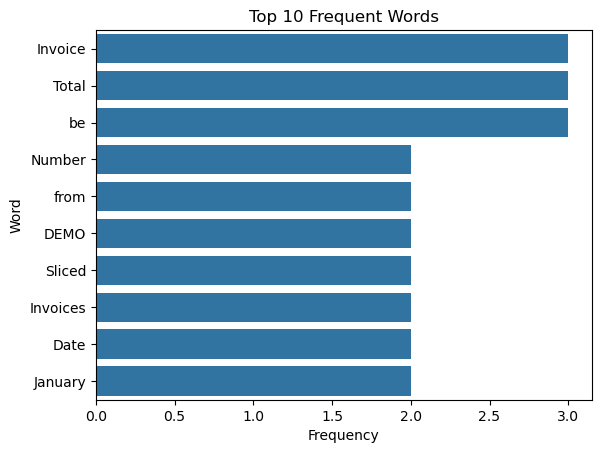

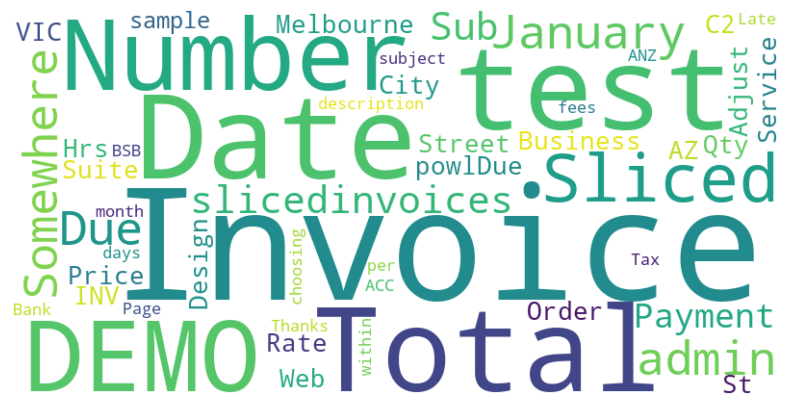

In [24]:
# Data visualization
visualize_word_frequency(word_freq)
generate_word_cloud(file_text)

#### By leveraging advanced NLP with transformer models like BART, the project efficiently extracts invoice details, generates summaries, and visualizes word frequencies and sentiment from PDF files. It provides an end-to-end solution for processing and analyzing multiple PDFs, making it ideal for industries requiring automated document handling, such as finance and procurement.